In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# recent_date = session.query(measurement).group_by(measurement.date).first()
recent_date = session.query(func.max(measurement.date)).scalar()

print(recent_date)

2017-08-23


In [12]:
from datetime import datetime as dt, timedelta

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Convert the most recent date to a datetime object

recent_date = dt.strptime(recent_date, '%Y-%m-%d') #uncheck if need to convert again

# Calculate the date one year from the last date in data set.
if recent_date:  # Ensure that the query returned a result
    one_year_ago = recent_date - timedelta(days=365) #uncheck if need to convert again

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# # Check the results
# for record in precipitation_data:
#     print(record)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)

df.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


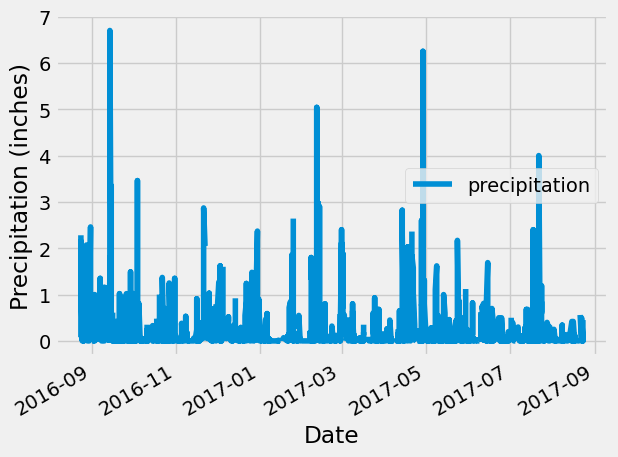

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('date', inplace=True)
df.plot()
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(station.station))).scalar()
print(total_stations)

9


In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    measurement.station,
    func.count(measurement.id)
).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()

for station, count in most_active_stations:
    print(f'Station ID: {station}, Count: {count}')

Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]  # Get the first station ID (highest row count) from the previous results

# Query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f'For station ID {most_active_station_id}:')
print(f'Lowest Temperature: {min_temp}')
print(f'Highest Temperature: {max_temp}')
print(f'Average Temperature: {avg_temp}')

For station ID USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_temp_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.station == most_active_station_id).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_temp = pd.DataFrame(most_active_temp_data, columns=['date', 'temperature'])

df_temp['date'] = pd.to_datetime(df_temp['date'])

# Sort the dataframe by date
df_temp.sort_values(by='date', inplace=True)

df_temp.head()

,date,temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


Text(0.5, 4.183333333333314, 'Temperature')

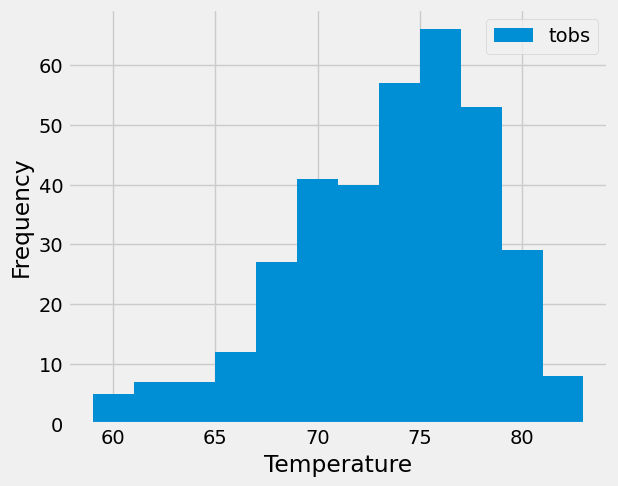

In [15]:
df_temp.set_index('date', inplace=True)
df_temp.plot(kind = 'hist')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()